<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/FORECAST002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install skforecast

In [ ]:
# 数据操作
# ==============================================================================
import pandas as pd  # 导入pandas库，用于数据处理
import numpy as np  # 导入numpy库，用于数值计算
import datetime  # 导入datetime库，用于日期时间处理

# 图表绘制
# ==============================================================================
import matplotlib.pyplot as plt  # 导入matplotlib.pyplot库，用于绘制静态图表
import plotly.graph_objects as go  # 导入plotly.graph_objects库，用于绘制交互式图表
import plotly.express as px  # 导入plotly.express库，用于快速绘制交互式图表
import seaborn as sns  # 导入seaborn库，用于统计数据可视化
from statsmodels.graphics.tsaplots import plot_acf  # 导入statsmodels.graphics.tsaplots库中的plot_acf函数，用于绘制自相关图
from statsmodels.graphics.tsaplots import plot_pacf  # 导入statsmodels.graphics.tsaplots库中的plot_pacf函数，用于绘制偏自相关图
from skforecast.plot import set_dark_theme  # 导入skforecast.plot库中的set_dark_theme函数，用于设置图表暗色主题

# 模型构建与预测
# ==============================================================================
import skforecast  # 导入skforecast库，用于时间序列预测
import sklearn  # 导入scikit-learn库，用于机器学习
import lightgbm  # 导入lightgbm库，用于梯度提升决策树
from skforecast.recursive import ForecasterRecursive  # 导入skforecast.recursive库中的ForecasterRecursive类，用于递归预测
from skforecast.model_selection import TimeSeriesFold  # 导入skforecast.model_selection库中的TimeSeriesFold类，用于时间序列交叉验证
from skforecast.model_selection import backtesting_forecaster  # 导入skforecast.model_selection库中的backtesting_forecaster函数，用于回测预测器
from lightgbm import LGBMRegressor  # 导入lightgbm库中的LGBMRegressor类，用于轻量级梯度提升回归
from sklearn.metrics import mean_absolute_error  # 导入sklearn.metrics库中的mean_absolute_error函数，用于计算平均绝对误差

# 警告处理
# ==============================================================================
import warnings  # 导入warnings库，用于处理警告信息
from skforecast.exceptions import LongTrainingWarning  # 导入skforecast.exceptions库中的LongTrainingWarning类，用于处理长时间训练警告
warnings.filterwarnings("once")  # 设置警告过滤器，只显示一次警告
warnings.simplefilter('ignore', category=LongTrainingWarning)  # 设置简单警告过滤器，忽略长时间训练警告

color = "\033[1m\033[38;5;208m"  # 设置控制台输出颜色
print(f"{color}Version skforecast: {skforecast.__version__}")  # 打印skforecast库的版本信息
print(f"{color}Version scikit-learn: {sklearn.__version__}")  # 打印scikit-learn库的版本信息
print(f"{color}Version lightgbm: {lightgbm.__version__}")  # 打印lightgbm库的版本信息
print(f"{color}Version pandas: {pd.__version__}")  # 打印pandas库的版本信息
print(f"{color}Version numpy: {np.__version__}")  # 打印numpy库的版本信息

Version skforecast: 0.14.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.5.0
Version pandas: 2.2.2
Version numpy: 1.26.4


**数据**

本文档中使用的数据是2013年4月28日至2022年1月1日期间以美元计价的比特币每日价格记录。数据集包含以下列：

* **Date（日期）**：记录的日期。
* **Open（开盘价）**：开盘价格，即资产（在本例中为比特币）在一天开始时交易的价格（美元）。
* **High（最高价）**：当日的最高价格，即比特币当日达到的最高价格（美元）。
* **Low（最低价）**：当日的最低价格，即比特币当日达到的最低价格（美元）。
* **Close（收盘价）**：收盘价格，即比特币在一天结束时交易的价格（美元）。
* **Volume（成交量）**：当日实际交易的总额（美元）。
* **Market Cap（市值）**：市值，即一家公司的所有股份的总价值，或者在比特币或其他加密货币的情况下，所有流通中的代币的总价值（美元）。

**注意**：加密货币市场是不间断的。它每周7天，每天24小时运行。然而，由于比特币或任何加密货币的价值可能在最后一秒发生波动，因此收盘价不一定与第二天的开盘价一致。


In [ ]:
# 数据下载
# ==============================================================================
data = pd.read_csv("https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/bitcoin.csv") # 从给定的URL读取CSV文件，并将其存储在pandas DataFrame中
data['date'] = pd.to_datetime(data['date']) # 将'date'列转换为datetime类型
data = data.set_index('date') # 将'date'列设置为DataFrame的索引
data = data.asfreq('D') # 将DataFrame的频率设置为每天（'D'）
data # 显示DataFrame

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<fro

,open,high,low,close,volume,market cap
date,,,,,,
2013-04-28,128.000100,128.000100,128.000100,128.000100,0.000000e+00,1.418304e+09
2013-04-29,134.444400,135.980000,132.100000,134.210000,0.000000e+00,1.488338e+09
2013-04-30,134.444000,147.488000,134.000000,144.540000,0.000000e+00,1.549501e+09
2013-05-01,144.000000,146.930000,134.050000,139.000000,0.000000e+00,1.578685e+09
2013-05-02,139.000000,139.890000,107.720000,116.990000,0.000000e+00,1.422546e+09
...,...,...,...,...,...,...
2021-12-28,50787.263830,51950.912600,50459.263641,50650.171445,4.695844e+10,9.655866e+11
2021-12-29,50667.988338,50667.988338,47411.717237,47637.888400,5.939821e+10,9.241336e+11
2021-12-30,47547.865500,48112.021472,46272.662981,46408.302671,8.826973e+10,8.998872e+11


**比特币减半作为外生变量**

减半是一个程序设定的事件，是某些加密货币设计和运行的一部分。矿工验证网络（在本例中为比特币）的交易区块，每次成功验证，他们都会收到一定数量的数字货币。这个数量会不时变化。

每当添加210,000个区块时，比特币区块链的奖励就会发生变化。这个被称为“减半”的事件大约每4年发生一次，并将矿工作为奖励收到的代币数量减半。

在比特币的历史中，已经发生了3次减半。当比特币挖矿开始时，矿工成功挖出一个区块会收到50个BTC。2012年，这个奖励减少到25个BTC；2016年，减少到12.5个BTC；2020年，在第三次减半后减少到6.25个BTC。每次减半都影响了价格，尽管不是在减半后的短期内。

本文旨在将距离下一次减半的剩余天数及其挖矿奖励作为外生变量，来预测比特币的价格。下一次减半预计大约在2024年发生，尽管确切日期未知。从Coinmarketcap网站获取的截至2022年1月14日的剩余区块数（121,400）和比特币网络每天开采的平均区块数（144，平均区块时间约10分钟）被用于确定减半日期。

注意：当将预测数据作为外生变量纳入模型时，由于它们是预测值，因此它们的误差会被引入预测模型中。

In [ ]:
# 比特币减半信息字典
# ==============================================================================
btc_halving = {
    "halving": [0, 1, 2, 3, 4],  # 减半次数列表：0, 1, 2, 3, 4
    "date": ["2009-01-03", "2012-11-28", "2016-07-09", "2020-05-11", np.nan],  # 减半日期列表，最后一个为NaN，表示下一次减半日期未知
    "reward": [50, 25, 12.5, 6.25, 3.125],  # 每次减半后的区块奖励列表：50, 25, 12.5, 6.25, 3.125
    "halving_block_number": [0, 210000, 420000, 630000, 840000],  # 每次减半时的区块高度列表：0, 210000, 420000, 630000, 840000
}

In [ ]:
# 下一次减半计算
# 根据coinmarketcap.com网站的数据，截至2022-01-14，下一次减半的剩余区块数作为起点
# ==============================================================================
remaining_blocks = 121400  # 剩余区块数：121400
blocks_per_day = 144  # 每日产生区块数：144
days = remaining_blocks / blocks_per_day  # 计算剩余天数
next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=days)  # 计算下一次减半的日期
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)  # 将时间部分设置为0
next_halving = next_halving.strftime('%Y-%m-%d')  # 将日期格式化为'YYYY-MM-DD'
btc_halving['date'][-1] = next_halving  # 将计算出的下一次减半日期添加到btc_halving字典中
print(f'The next halving will occur on approximately: {next_halving}')  # 打印下一次减半的日期

The next halving will occur on approximately: 2024-05-06


In [ ]:
# 在数据集中包含奖励和到下一次减半的倒计时
# ==============================================================================
data["reward"] = np.nan  # 在DataFrame中创建'reward'列，并用NaN填充
data["countdown_halving"] = np.nan  # 在DataFrame中创建'countdown_halving'列，并用NaN填充
for i in range(len(btc_halving["halving"]) - 1):  # 遍历减半事件（除了最后一个，因为它代表下一次减半）

    # 每个减半的开始和结束日期
    if btc_halving["date"][i] < data.index.min().strftime("%Y-%m-%d"):  # 如果当前减半的开始日期早于数据集的最小日期
        start_date = data.index.min().strftime("%Y-%m-%d")  # 将开始日期设置为数据集的最小日期
    else:
        start_date = btc_halving["date"][i]  # 否则，将开始日期设置为当前减半的日期

    end_date = btc_halving["date"][i + 1]  # 将结束日期设置为下一次减半的日期
    mask = (data.index >= start_date) & (data.index < end_date)  # 创建一个布尔掩码，用于选择当前减半期间的数据

    # 用挖矿奖励填充'reward'列
    data.loc[mask, "reward"] = btc_halving["reward"][i]  # 将当前减半的奖励值分配给掩码选中的行

    # 用剩余天数填充'countdown_halving'列
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)  # 计算到下一次减半的天数差

    data.loc[mask, "countdown_halving"] = np.arange(time_to_next_halving.days)[::-1][
        : mask.sum()
    ]  # 创建一个倒序的天数序列，并将其分配给掩码选中的行

In [ ]:
# 检查数据是否正确创建
# ==============================================================================
print("Second halving:", btc_halving["date"][2])  # 打印第二次减半的日期
display(data.loc["2016-07-08":"2016-07-09"])  # 显示2016年7月8日至2016年7月9日的数据
print("")  # 打印一个空行

print("Third halving:", btc_halving["date"][3])  # 打印第三次减半的日期
display(data.loc["2020-05-10":"2020-05-11"])  # 显示2020年5月10日至2020年5月11日的数据
print("")  # 打印一个空行

print("Next halving:", btc_halving["date"][4])  # 打印下一次减半的日期
data.tail(2)  # 显示DataFrame的最后两行

Second halving: 2016-07-09


,open,high,low,close,volume,market cap,reward,countdown_halving
date,,,,,,,,
2016-07-08,677.331,682.432,611.834,639.667,1.892361e+08,1.015055e+10,25.0,0.0
2016-07-09,640.562,666.707,636.467,666.707,2.061508e+08,1.020561e+10,12.5,1401.0



Third halving: 2020-05-11


,open,high,low,close,volume,market cap,reward,countdown_halving
date,,,,,,,,
2020-05-10,9814.400817,9900.431521,9559.705894,9570.005988,3.675906e+10,1.786858e+11,12.50,0.0
2020-05-11,9554.216377,9554.216377,8388.959555,8745.152545,4.909643e+10,1.598261e+11,6.25,1455.0



Next halving: 2024-05-06


,open,high,low,close,volume,market cap,reward,countdown_halving
date,,,,,,,,
2021-12-31,46430.481224,47876.491839,46077.722276,47161.009200,1.229248e+11,8.907742e+11,6.25,856.0
2022-01-01,47139.359000,48505.999700,45712.566592,46304.949594,7.810027e+10,8.945653e+11,6.25,855.0


**图形探索**

当需要生成预测模型时，绘制时间序列值可能很有用。这可以识别趋势和季节性等模式。

**蜡烛图**

蜡烛图是一种金融图表风格，用于描述证券、衍生品或货币的价格变动。粗体部分显示一段时间内开盘价和收盘价之间的变化，而阴影部分显示该期间达到的最小值和最大值。


In [ ]:
# 使用Plotly绘制交互式蜡烛图
# ==============================================================================
candlestick = go.Candlestick(
    x=data.index,  # 设置x轴为日期索引
    open=data.open,  # 设置开盘价
    close=data.close,  # 设置收盘价
    low=data.low,  # 设置最低价
    high=data.high,  # 设置最高价
)
fig = go.Figure(data=[candlestick])  # 创建Figure对象，并将蜡烛图数据添加到其中
fig.update_layout(
    width=750,  # 设置图表宽度
    height=350,  # 设置图表高度
    title=dict(text="<b>Bitcoin/USD Chart</b>", font=dict(size=20)),  # 设置图表标题
    yaxis_title=dict(text="Price (USD)", font=dict(size=15)),  # 设置y轴标题
    margin=dict(l=10, r=20, t=80, b=20),  # 设置图表边距
    shapes=[  # 添加形状（竖线）
        dict(
            x0=btc_halving["date"][2],  # 设置第一条竖线的x坐标
            x1=btc_halving["date"][2],  # 设置第一条竖线的x坐标
            y0=0,  # 设置第一条竖线的y坐标起点
            y1=1,  # 设置第一条竖线的y坐标终点
            xref="x",  # 设置x坐标参考系
            yref="paper",  # 设置y坐标参考系
            line_width=2,  # 设置线宽
        ),
        dict(
            x0=btc_halving["date"][3],  # 设置第二条竖线的x坐标
            x1=btc_halving["date"][3],  # 设置第二条竖线的x坐标
            y0=0,  # 设置第二条竖线的y坐标起点
            y1=1,  # 设置第二条竖线的y坐标终点
            xref="x",  # 设置x坐标参考系
            yref="paper",  # 设置y坐标参考系
            line_width=2,  # 设置线宽
        ),
        dict(
            x0=btc_halving["date"][4],  # 设置第三条竖线的x坐标
            x1=btc_halving["date"][4],  # 设置第三条竖线的x坐标
            y0=0,  # 设置第三条竖线的y坐标起点
            y1=1,  # 设置第三条竖线的y坐标终点
            xref="x",  # 设置x坐标参考系
            yref="paper",  # 设置y坐标参考系
            line_width=2,  # 设置线宽
        ),
    ],
    annotations=[  # 添加注释
        dict(
            x=btc_halving["date"][2],  # 设置第一条注释的x坐标
            y=1,  # 设置第一条注释的y坐标
            xref="x",  # 设置x坐标参考系
            yref="paper",  # 设置y坐标参考系
            showarrow=False,  # 不显示箭头
            xanchor="left",  # 设置注释文本的水平对齐方式
            text="Second halving",  # 设置注释文本
        ),
        dict(
            x=btc_halving["date"][3],  # 设置第二条注释的x坐标
            y=1,  # 设置第二条注释的y坐标
            xref="x",  # 设置x坐标参考系
            yref="paper",  # 设置y坐标参考系
            showarrow=False,  # 不显示箭头
            xanchor="left",  # 设置注释文本的水平对齐方式
            text="Third halving",  # 设置注释文本
        ),
        dict(
            x=btc_halving["date"][4],  # 设置第三条注释的x坐标
            y=1,  # 设置第三条注释的y坐标
            xref="x",  # 设置x坐标参考系
            yref="paper",  # 设置y坐标参考系
            showarrow=False,  # 不显示箭头
            xanchor="left",  # 设置注释文本的水平对齐方式
            text="Fourth halving",  # 设置注释文本
        ),
    ],
    xaxis_rangeslider_visible=False,  # 隐藏x轴范围滑块
)
fig.show()  # 显示图表

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<fro

**数据分布**

展示了比特币收盘价（变量 `close`）的分布情况。


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



Text(0.5, 0, 'Price (USD)')

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



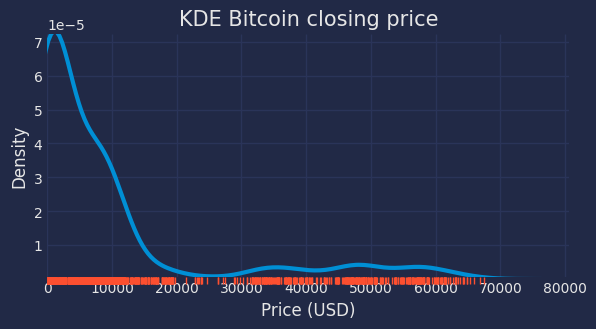

In [ ]:
# 比特币收盘价的KDE分布
# ==============================================================================
set_dark_theme()  # 设置图表为暗色主题
fig, ax = plt.subplots(figsize=(6, 3))  # 创建一个图形和轴对象，设置图形大小
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)  # 绘制比特币收盘价的核密度估计（KDE）图，设置线宽
r = sns.rugplot(data=data, x='close', ax=ax, height=-.03, clip_on=False)  # 绘制比特币收盘价的地毯图，设置高度和裁剪
p.set(xlim=(0, None))  # 设置x轴的下限为0，上限自动调整
p.set_title('KDE Bitcoin closing price', fontsize=15)  # 设置图表标题和字体大小
p.set_xlabel('Price (USD)')  # 设置x轴标签

**数据分布分析**

研究数据显示，大部分价格分布在20,000美元以下。这个阶段对应于2013年至2020年9月之间的时期。自2021年以来，价格一直处于35,000至67,500美元的范围内。

尝试对具有高度不对称分布且随时间推移具有不同数量级的时间序列进行建模可能会导致复杂情况。一种策略是建模变化量（增量），而不是直接建模值，以尽量减少这些问题。可以进一步简化，仅指示价格是否比前一天上涨或下跌。

**注意**：当分布不对称时，建模增量而不是价格可能会产生更对称的分布。


**年度价格走势**

In [ ]:
# 定位每年对应的日期
# ==============================================================================
years = list(data.index.year.unique())  # 获取数据集中所有唯一的年份列表
df_plot = pd.DataFrame()  # 创建一个空的DataFrame用于存储每年份的统计信息
for year in years:  # 遍历每个年份

    year_open = data.loc[data.index.year == year, "open"].iloc[0]  # 获取该年份的第一个开盘价
    year_close = data.loc[data.index.year == year, "close"].iloc[-1]  # 获取该年份的最后一个收盘价
    year_low = data.loc[data.index.year == year, "low"].min()  # 获取该年份的最低价
    year_high = data.loc[data.index.year == year, "high"].max()  # 获取该年份的最高价

    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high])  # 将该年份的统计信息添加到df_plot DataFrame中
df_plot = df_plot.T  # 转置DataFrame，使年份成为索引
df_plot = df_plot.set_axis(["open", "close", "low", "high"], axis=1)  # 设置列名为"open", "close", "low", "high"

# 计算年份开盘价和收盘价之间的百分比变化
# ==============================================================================
df_plot["year_change"] = 100 * (df_plot["close"] - df_plot["open"]) / df_plot["open"]  # 计算每年收盘价相对于开盘价的百分比变化
df_plot.head(3)  # 显示DataFrame的前三行

,open,close,low,high,year_change
2013,128.0001,756.130,65.526,1156.140,490.726101
2014,760.3200,310.610,289.296,1017.120,-59.147464
2015,310.7370,426.371,171.510,495.562,37.212820


In [ ]:
# 创建一个包含绘图百分比变化注释的字典列表
# ==============================================================================
annotations_list = []  # 初始化一个空列表，用于存储注释字典
max_high = df_plot["high"].max()  # 获取最高价的最大值
for year in years:  # 遍历所有年份

    df_aux = df_plot.loc[df_plot.index == year,]  # 获取当前年份的数据子集
    loc_x = pd.to_datetime(df_aux.index[0], format="%Y")  # 将年份转换为datetime对象作为x坐标
    loc_y = df_aux["high"].values[0] / max_high + 0.05  # 计算y坐标，相对于最高价进行归一化并加上偏移量
    text = "{:.1f}%".format(df_aux["year_change"].values[0])  # 格式化百分比变化文本

    annotation = dict(  # 创建注释字典
        x=loc_x,  # 设置x坐标
        y=loc_y,  # 设置y坐标
        xref="x",  # 设置x坐标参考系
        yref="paper",  # 设置y坐标参考系
        showarrow=False,  # 不显示箭头
        xanchor="center",  # 设置文本水平对齐方式
        text=text,  # 设置注释文本
    )

    annotations_list.append(annotation)  # 将注释字典添加到列表中

# 使用Plotly绘制交互式蜡烛图
# ==============================================================================
candlestick = go.Candlestick(
    x=pd.to_datetime(df_plot.index, format="%Y"),  # 设置x轴为年份datetime对象
    open=df_plot.open,  # 设置开盘价
    close=df_plot.close,  # 设置收盘价
    low=df_plot.low,  # 设置最低价
    high=df_plot.high,  # 设置最高价
)
fig = go.Figure(data=[candlestick])  # 创建Figure对象，并将蜡烛图数据添加到其中
fig.update_layout(
    width=750,  # 设置图表宽度
    height=350,  # 设置图表高度
    title=dict(text="<b>Bitcoin/USD yearly chart</b>", font=dict(size=20)),  # 设置图表标题
    yaxis_title=dict(text="Price (USD)", font=dict(size=13)),  # 设置y轴标题
    margin=dict(l=0, r=20, t=55, b=20),  # 设置图表边距
    xaxis_rangeslider_visible=False,  # 隐藏x轴范围滑块
    annotations=annotations_list,  # 添加注释列表
)
fig.show("colab")  # 显示图表

**年、月、周的季节性**

In [ ]:
# 定位每个月对应的日期
# ==============================================================================
years = list(data.index.year.unique())  # 获取数据集中所有唯一的年份列表
df_plot = pd.DataFrame()  # 创建一个空的DataFrame用于存储每月统计信息
for year in years:  # 遍历每个年份
    for month in range(12):  # 遍历每个月份（0-11）

        start_date = pd.to_datetime(f"{year}-{month+1}-01", format="%Y-%m-%d")  # 创建当月的第一天datetime对象
        end_date = start_date + pd.offsets.MonthBegin()  # 创建下个月的第一天datetime对象
        mask = (data.index >= start_date) & (data.index < end_date)  # 创建布尔掩码，用于选择当月的数据

        if not data.loc[mask, :].empty:  # 如果当月有数据

            month_open = data.loc[mask, "open"].iloc[0]  # 获取当月的第一个开盘价
            month_close = data.loc[mask, "close"].iloc[-1]  # 获取当月的最后一个收盘价
            month_low = data.loc[mask, "low"].min()  # 获取当月的最低价
            month_high = data.loc[mask, "high"].max()  # 获取当月的最高价

            serie = pd.Series([month_open, month_close, month_low, month_high])  # 创建包含当月统计信息的Series
            df_aux = pd.DataFrame(serie, columns=[f"{str(month+1).zfill(2)}-{year}"])  # 创建包含Series的DataFrame，列名为"MM-YYYY"

            if df_plot.empty:  # 如果df_plot为空
                df_plot = df_aux.copy()  # 将df_aux复制到df_plot
            else:  # 如果df_plot不为空
                df_plot = pd.concat([df_plot, df_aux], axis=1)  # 将df_aux与df_plot按列拼接
df_plot = df_plot.T  # 转置DataFrame，使月份-年份成为索引
df_plot = df_plot.set_axis(["open", "close", "low", "high"], axis=1)  # 设置列名为"open", "close", "low", "high"

In [ ]:
# 年度季节性的箱线图
# ==============================================================================
df_plot["month"] = pd.to_datetime(df_plot.index, format="%m-%Y").month  # 从索引中提取月份并添加到DataFrame中

# fig 1 月度箱线图
fig1 = px.box(
    df_plot.sort_values("month"),  # 按月份排序DataFrame
    x="month",  # 设置x轴为月份
    y="close",  # 设置y轴为收盘价
)

# fig 2 每月收盘价中位数折线图
df_median = pd.DataFrame(df_plot.groupby("month")["close"].median()).reset_index()  # 计算每月收盘价的中位数
fig2 = px.line(
    df_median,  # 设置数据源为每月中位数
    x="month",  # 设置x轴为月份
    y="close",  # 设置y轴为中位数
    markers=True,  # 显示数据点标记
)

fig = go.Figure(data=fig1.data + fig2.data)  # 合并箱线图和折线图的数据
fig.update_layout(
    width=650,  # 设置图表宽度
    height=350,  # 设置图表高度
    title=dict(text="<b>BTC Price per month</b>", font=dict(size=20)),  # 设置图表标题
    yaxis_title=dict(text="Price (USD)", font=dict(size=13)),  # 设置y轴标题
    xaxis=dict(tickmode="linear"),  # 设置x轴刻度模式为线性
    xaxis_title=dict(text="month", font=dict(size=13)),  # 设置x轴标题
    margin=dict(l=0, r=20, t=55, b=20),  # 设置图表边距
)
fig.show()  # 显示图表

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to fin

In [ ]:
# 月度季节性的箱线图
# ==============================================================================
data["day"] = pd.Series(data.index).dt.day.values  # 从日期索引中提取日份，并添加到DataFrame中

# fig 1 每日箱线图
fig1 = px.box(data.sort_values("day"), x="day", y="close")  # 创建按日份排序的箱线图，x轴为日份，y轴为收盘价

# fig 2 每日收盘价中位数折线图
df_median = pd.DataFrame(data.groupby("day")["close"].median()).reset_index()  # 计算每日收盘价的中位数
fig2 = px.line(df_median, x="day", y="close", markers=True)  # 创建每日中位数的折线图，x轴为日份，y轴为中位数，显示数据点标记

fig = go.Figure(data=fig1.data + fig2.data)  # 合并箱线图和折线图的数据

fig.update_layout(
    width=750,  # 设置图表宽度
    height=350,  # 设置图表高度
    title=dict(text="<b>BTC Price per day of the month</b>", font=dict(size=20)),  # 设置图表标题
    yaxis_title=dict(text="Price (USD)", font=dict(size=13)),  # 设置y轴标题
    xaxis=dict(tickmode="linear", tickangle=0, range=[0.5, 31.5]),  # 设置x轴刻度模式为线性，刻度角度为0，范围为0.5到31.5
    xaxis_title=dict(text="day", font=dict(size=13)),  # 设置x轴标题
    margin=dict(l=0, r=20, t=55, b=20),  # 设置图表边距
)
fig.show()  # 显示图表

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



In [ ]:
# 周度季节性的箱线图
# ==============================================================================
data["weekday"] = data.index.day_of_week + 1  # 从日期索引中提取星期几（1-7），并添加到DataFrame中

# fig 1 每日箱线图
fig1 = px.box(data.sort_values("weekday"), x="weekday", y="close")  # 创建按星期几排序的箱线图，x轴为星期几，y轴为收盘价

# fig 2 每日收盘价中位数折线图
df_median = pd.DataFrame(data.groupby("weekday")["close"].median()).reset_index()  # 计算每日收盘价的中位数
fig2 = px.line(df_median, x="weekday", y="close", markers=True)  # 创建每日中位数的折线图，x轴为星期几，y轴为中位数，显示数据点标记

fig = go.Figure(data=fig1.data + fig2.data)  # 合并箱线图和折线图的数据

fig.update_layout(
    width=600,  # 设置图表宽度
    height=300,  # 设置图表高度
    title=dict(text="<b>BTC Price per day of the week</b>", font=dict(size=20)),  # 设置图表标题
    yaxis_title=dict(text="Price (USD)", font=dict(size=13)),  # 设置y轴标题
    xaxis=dict(tickmode="linear"),  # 设置x轴刻度模式为线性
    xaxis_title=dict(text="weekday", font=dict(size=13)),  # 设置x轴标题
    margin=dict(l=0, r=20, t=55, b=20),  # 设置图表边距
)
fig.show()  # 显示图表

通常，具有自回归模式的时间序列会产生重复的形状（趋势、季节性、周期性因素）。关于比特币，在年底和年初出现了一定的年度季节性，价格波动较大。在月度和周度区间内，没有明显的季节性，分布非常相似。

**自相关性图**

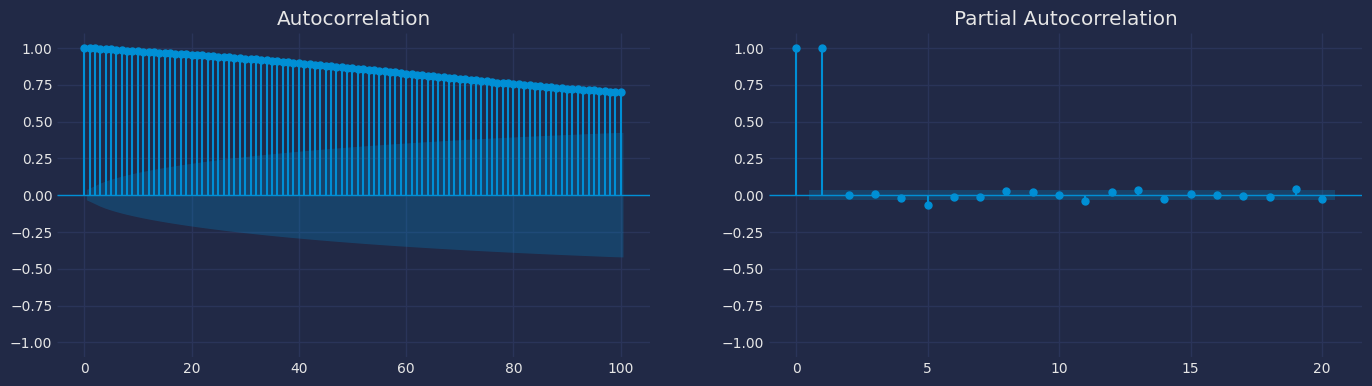

In [ ]:
# 自相关图
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))  # 创建一个包含两个子图的图形，设置图形大小
axes = axes.flat  # 将axes数组展平，方便遍历

plot_acf(data.close, ax=axes[0], linewidth=1, lags=100)  # 绘制收盘价的自相关图，设置线宽和滞后阶数
axes[0].set_ylim(-1.1, 1.1)  # 设置第一个子图的y轴范围

plot_pacf(data.close, ax=axes[1], lags=20, method='ywm', linewidth=1)  # 绘制收盘价的偏自相关图，设置滞后阶数、方法和线宽
axes[1].set_ylim(-1.1, 1.1)  # 设置第二个子图的y轴范围

plt.show()  # 显示图形

从自相关图中可以看出，只有一阶滞后与零阶滞后存在相关关系，后续的滞后阶数都未达到显著性水平。

**基准 - 随机游走模拟**

在生成预测模型时，最好确定一个基础模型或基准，以便比较每个提出的迭代或模型。就金融而言，根据随机游走理论，市场价格的行为是随机的，而不是其时间序列的函数。因此，$t_{n+1}$
的最佳估计值是
$t_{n}$
的值加上一个不可预测的变化。

尽管有广泛的时间序列可用，但正如在图形探索中确定的那样，它呈现出价格高度差异化的时期。仅使用最近两年的数据。


In [ ]:
# 选择训练集-测试集日期
# ==============================================================================
start_train = '2020-01-01 00:00:00'  # 设置训练集开始日期
end_train = '2021-06-30 23:59:59'  # 设置训练集结束日期

print(f"Complete time series : {data.index.min()} --- {data.index.max()}  (n={len(data)})")  # 打印完整时间序列的开始日期、结束日期和数据点数量
print(f"Train dates          : {data.loc[start_train:end_train].index.min()} --- {data.loc[start_train:end_train].index.max()}  (n={len(data.loc[start_train:end_train])})")  # 打印训练集的开始日期、结束日期和数据点数量
print(f"Test dates           : {data.loc[end_train:].index.min()} --- {data.loc[end_train:].index.max()}  (n={len(data.loc[end_train:])})")  # 打印测试集的开始日期、结束日期和数据点数量

Complete time series : 2013-04-28 00:00:00 --- 2022-01-01 00:00:00  (n=3171)
Train dates          : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Test dates           : 2021-07-01 00:00:00 --- 2022-01-01 00:00:00  (n=185)


正如上面提到的，随机游走表明，$t_{n+1}$ 的最佳估计值是 $t_{n}$ 的值加上一个不可预测的变化。因此，最简单的可行模型使用 $t_{n}$ 的值作为 $t_{n+1}$ 值的预测。它被设置为基准模型。


In [ ]:
# 随机游走模拟
# ==============================================================================
df_rw = data[['close']].copy()  # 创建一个只包含收盘价的DataFrame副本
df_rw['pred_close'] = df_rw['close'].shift(1)  # 创建一个预测收盘价的列，其值为前一天的收盘价

# 测试误差
# ==============================================================================
y_true = df_rw.loc[end_train:, 'close']  # 获取测试集中的真实收盘价
y_pred = df_rw.loc[end_train:, 'pred_close']  # 获取测试集中的预测收盘价
metric = mean_absolute_error(y_true, y_pred)  # 计算平均绝对误差（MAE）
print(f'Test error: {metric}')  # 打印测试误差
display(df_rw.loc[end_train:,].head(4))  # 显示测试集前四行数据

Test error: 1260.3677521425916


,close,pred_close
date,,
2021-07-01,35060.428966,35840.386468
2021-07-02,33628.670000,35060.428966
2021-07-03,33846.007087,33628.670000
2021-07-04,34698.303129,33846.007087


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to fin

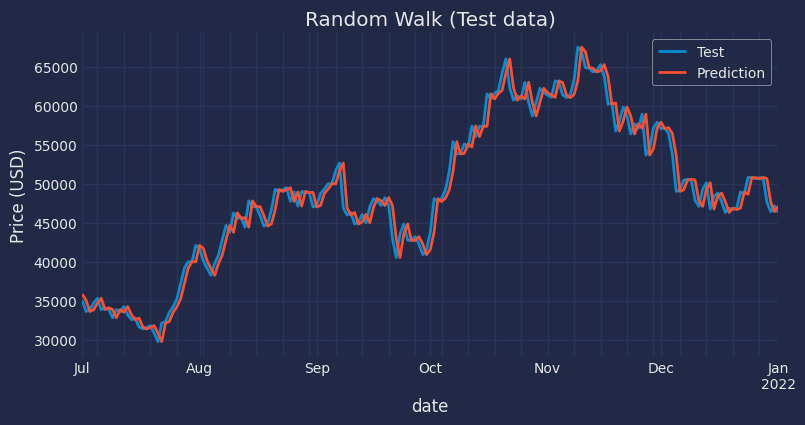

In [ ]:
# 绘图
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))  # 创建一个图形和轴对象，设置图形大小
df_rw.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')  # 绘制测试集真实收盘价，设置线宽和标签
df_rw.loc[end_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Prediction')  # 绘制测试集预测收盘价，设置线宽和标签
ax.set_title('Random Walk (Test data)')  # 设置图表标题
ax.set_ylabel('Price (USD)')  # 设置y轴标签
ax.legend()  # 显示图例

In [ ]:
# 创建包含模型误差信息的DataFrame
# ==============================================================================
df_errors = pd.DataFrame({  # 创建一个DataFrame，用于存储模型误差信息
                'model': 'Base - Random Walk',  # 模型名称：基准 - 随机游走
                'lags': 1,  # 滞后阶数：1
                'test_error': metric,  # 测试误差：之前计算的MAE
                'exog_variables': False  # 是否使用了外生变量：否
                },
                index=[0]  # 设置索引为0
            )
df_errors  # 显示DataFrame

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1260.367752,False


**递归自回归预测器**

使用带有 LightGBM 回归器的自回归预测器（ForecasterRecursive）来建模比特币价格。LightGBM 是微软开发的梯度提升算法的一种实现，通常能取得出色的结果。

前面的章节显示，除了第一个滞后之外，不存在自相关性。验证这一点的一种方法是训练多个具有递增滞后量的模型，并检查误差是否没有减少。这种方法可以通过回测来完成，使用 `steps = 1`（仅预测序列中的下一个值， $t_{n+1}$ ），它重现了随机游走模型的原理。


In [ ]:
# 使用不同滞后阶数进行预测器回测
# ==============================================================================
lags = [1, 7, 30]  # 定义滞后阶数列表
metrics = []  # 初始化一个空列表，用于存储回测误差
predictions_list = []  # 初始化一个空列表，用于存储预测结果列表
for lag in lags:  # 遍历每个滞后阶数

    # 创建预测器
    forecaster = ForecasterRecursive(
                     regressor = LGBMRegressor(random_state=123, verbose=-1),  # 创建LightGBM回归器
                     lags = lag,  # 设置滞后阶数
                     transformer_y = None  # 设置目标变量转换器为None
                 )

    # 回测测试数据，单步预测
    cv = TimeSeriesFold(
            steps = 1,  # 设置预测步长为1
            initial_train_size = len(data.loc[start_train:end_train, 'close']),  # 设置初始训练集大小
            fixed_train_size = True,  # 设置固定训练集大小
            refit = True,  # 设置每次折叠都重新拟合模型
         )
    metric, predictions = backtesting_forecaster(
                              forecaster = forecaster,  # 传入预测器
                              y = data.loc[start_train:, 'close'],  # 传入目标变量
                              cv = cv,  # 传入交叉验证对象
                              metric = 'mean_absolute_error',  # 设置评估指标为平均绝对误差
                              verbose = False,  # 设置不显示详细信息
                              show_progress = True,  # 设置显示进度条
                          )

    metrics.append(metric.at[0, 'mean_absolute_error'])  # 将回测误差添加到列表中
    predictions_list.append(predictions)  # 将预测结果添加到列表中

  0%|          | 0/185 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

  0%|          | 0/185 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

  0%|          | 0/185 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

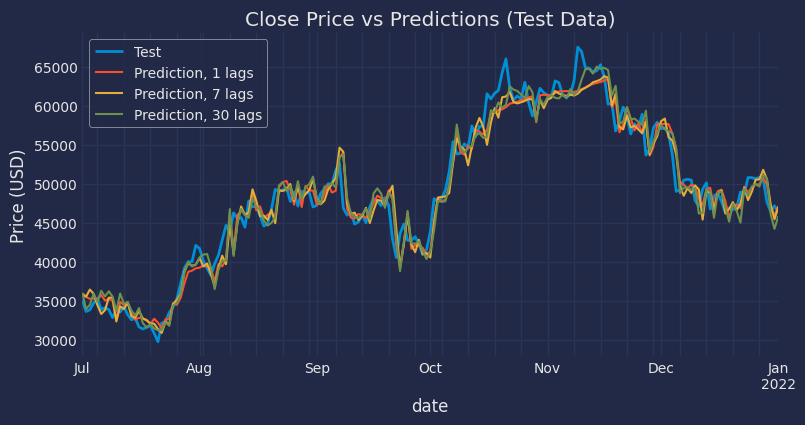

In [ ]:
# 绘图
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))  # 创建一个图形和轴对象，设置图形大小
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')  # 绘制测试集真实收盘价，设置线宽和标签

# 绘制不同滞后阶数的测试集预测结果
for predictions, lag in zip(predictions_list, lags):  # 遍历预测结果列表和滞后阶数列表
    predictions = predictions.rename(columns={'pred': f'Prediction, {lag} lags'})  # 重命名预测结果列，添加滞后阶数信息
    predictions.plot(ax=ax)  # 绘制预测结果

ax.set_title('Close Price vs Predictions (Test Data)')  # 设置图表标题
ax.set_ylabel('Price (USD)')  # 设置y轴标签
ax.legend()  # 显示图例

In [ ]:
# 模型测试误差DataFrame
# ==============================================================================
model = 'LGBMRegressor'  # 设置模型名称为LGBMRegressor
df_errors = pd.concat([  # 将新的DataFrame与df_errors DataFrame拼接
                df_errors,  # 原始的df_errors DataFrame
                pd.DataFrame({  # 创建一个新的DataFrame，包含LGBMRegressor模型的信息
                    'model': model,  # 模型名称
                    'lags': lags,  # 滞后阶数列表
                    'test_error': metrics,  # 测试误差列表
                    'exog_variables': False  # 是否使用外生变量
                })
             ]).reset_index(drop=True)  # 重置索引并删除原始索引列
df_errors.sort_values(by='test_error')  # 按测试误差排序DataFrame

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1260.367752,False
1,LGBMRegressor,1,1527.440787,False
2,LGBMRegressor,7,1546.268058,False
3,LGBMRegressor,30,1561.058347,False


**测试误差**（反映了每个模型的泛化能力）显示，尽管从过去纳入了更多信息（滞后数量），但没有一个模型比基准模型有所改进。鉴于这些结果，我们测试了其他替代方案，例如将外生变量纳入序列。


**使用外生变量进行预测**

在之前的例子中，仅使用了预测变量自身的滞后项作为预测因子。在某些情况下，可以获取关于其他变量的信息，这些变量的未来值是已知的，并且可以作为模型中的附加预测因子。典型的例子有：

* 节假日（本地、国家...）
* 年份中的月份
* 星期几
* 一天中的时间

在本例中，使用了比特币减半部分产生的变量，并在研究季节性之后，使用了年份中的月份。

**注意**：`reward`（奖励）和 `month`（月份）变量虽然被编码为数字，但它们是分类变量，因此最好更改它们的存储类型。由于这些变量没有很多级别，因此使用独热编码转换将它们纳入模型。


In [ ]:
# 对分类变量进行独热编码
# ==============================================================================
data['month'] = data.index.month  # 从日期索引中提取月份，并添加到DataFrame中
data = pd.get_dummies(data, columns=['reward', 'month'], dtype=int)  # 对'reward'和'month'列进行独热编码，数据类型为整数
data.head(2)  # 显示DataFrame的前两行

,open,high,low,close,volume,market cap,countdown_halving,day,weekday,reward_6.25,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,128.0001,128.0001,128.0001,128.0001,0.0,1.418304e+09,1167.0,28,7,0,...,0,1,0,0,0,0,0,0,0,0
2013-04-29,134.4444,135.9800,132.1000,134.2100,0.0,1.488338e+09,1166.0,29,1,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# 选择所有外生变量，包括独热编码得到的变量
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'month'))]  # 选择以'reward'或'month'开头的列名，即独热编码生成的列
exog.extend(['countdown_halving'])  # 将'countdown_halving'列名添加到外生变量列表中
exog  # 显示外生变量列表

['reward_6.25',
 'reward_12.5',
 'reward_25.0',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'countdown_halving']

In [ ]:
# 使用外生变量进行预测器回测
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),  # 创建LightGBM回归器，设置随机种子和不显示详细信息
                 lags = 1,  # 设置滞后阶数为1
                 transformer_y = None,  # 设置目标变量转换器为None
                 transformer_exog = None  # 设置外生变量转换器为None
             )
# 回测测试数据，单步预测
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,  # 传入预测器
                          y = data.loc[start_train:, 'close'],  # 传入目标变量
                          exog = data.loc[start_train:, exog],  # 传入外生变量
                          cv = cv,  # 传入交叉验证对象
                          metric = 'mean_absolute_error',  # 设置评估指标为平均绝对误差
                          verbose = False,  # 设置不显示详细信息
                          show_progress = True  # 设置显示进度条
                      )

  0%|          | 0/185 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all

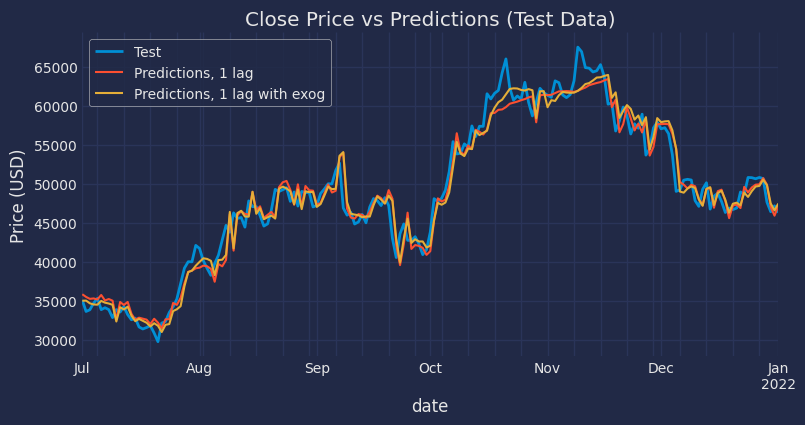

In [ ]:
# 绘图
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 4))  # 创建一个图形和轴对象，设置图形大小
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')  # 绘制测试集真实收盘价，设置线宽和标签

# 绘制不带外生变量的1阶滞后预测结果
predictions_no_exog = predictions_list[0].rename(columns={'pred': f'Predictions, 1 lag'})  # 重命名预测结果列，添加标签
predictions_no_exog.plot(ax=ax)  # 绘制预测结果

# 绘制带外生变量的1阶滞后预测结果
predictions_exog = predictions.rename(columns={'pred': f'Predictions, 1 lag with exog'})  # 重命名预测结果列，添加标签
predictions_exog.plot(ax=ax)  # 绘制预测结果

ax.set_title('Close Price vs Predictions (Test Data)')  # 设置图表标题
ax.set_ylabel('Price (USD)')  # 设置y轴标签
ax.legend()  # 显示图例

In [ ]:
# 模型测试误差DataFrame
# ==============================================================================
model = 'LGBMRegressor'  # 设置模型名称为LGBMRegressor
df_errors = pd.concat([  # 将新的DataFrame与df_errors DataFrame拼接
                df_errors,  # 原始的df_errors DataFrame
                pd.DataFrame({  # 创建一个新的DataFrame，包含LGBMRegressor模型的信息
                    'model': model,  # 模型名称
                    'lags': lags,  # 滞后阶数列表
                    'test_error': metrics,  # 测试误差列表
                    'exog_variables': True  # 是否使用外生变量，设置为True
                })
             ]).reset_index(drop=True)  # 重置索引并删除原始索引列
df_errors.sort_values(by='test_error')  # 按测试误差排序DataFrame


,model,lags,test_error,exog_variables
0,Base - Random Walk,1,1260.367752,False
1,LGBMRegressor,1,1527.440787,False
4,LGBMRegressor,1,1527.440787,True
2,LGBMRegressor,7,1546.268058,False
5,LGBMRegressor,7,1546.268058,True
3,LGBMRegressor,30,1561.058347,False
6,LGBMRegressor,30,1561.058347,True


即使纳入外生变量，模型也没有比基准（随机游走）有所改进。

**结论**

比特币价格不遵循自回归模式。 $t_{n+1}$ 的最佳估计值是 $t_{n}$ 的值加上一个不可预测的变化。通过描述性分析尽早识别出这种相关性的缺失，可以避免不必要的建模工作。

当获得没有自相关性的时间序列时，应该寻找能够帮助解决问题的外生变量。例如，为了短期（小时）预测比特币的价格，可以使用通过推文分析得到的市场情绪、所谓关键意见领袖的影响、最相关新闻的分析等外生变量。

由于 Skforecast 提供的功能，在预测问题中使用机器学习模型非常简单。


In [ ]:
!pip install session-info

In [ ]:
import session_info
session_info.show(html=False)

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_GenerativeAIImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



-----
lightgbm            4.5.0
matplotlib          3.10.0
numpy               1.26.4
pandas              2.2.2
plotly              5.24.1
seaborn             0.13.2
session_info        1.0.0
skforecast          0.14.0
sklearn             1.6.1
statsmodels         0.14.4
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Linux-6.1.85+-x86_64-with-glibc2.35
-----
Session information updated at 2025-03-10 12:46


金融市场（如股票市场）的预测是否可行，这一问题在学术界和实务界存在长期争议。现有理论既包含对预测不可行的论证，也提出了部分支持可行性的框架。以下从不可行性理论与可行性理论两个角度进行综合分析：

---

### **一、市场预测不可行的理论支持**
1. **有效市场假说（Efficient Market Hypothesis, EMH）**  
   该假说认为，市场价格已充分反映所有可获得信息，投资者无法通过分析信息获取超额收益。根据信息反映程度，EMH分为三种形式：  
   - **弱式有效**：价格已反映历史信息，技术分析无效；  
   - **半强式有效**：价格包含所有公开信息，基本面分析无效；  
   - **强式有效**：价格包含所有公开和未公开信息，任何分析均无效。  
   支持者认为，市场参与者会迅速消化新信息，导致预测无法持续有效。

2. **混沌理论与不可预测性**  
   金融市场属于复杂系统，微小扰动可能引发连锁反应（如“蝴蝶效应”），长期预测因系统演化周期长而难以精准。例如，类比天气预测，指出长期市场预测如同“数年后的天气预测”，几乎不可能，但短期预测可能具备一定可行性。

3. **随机漫步理论（Random Walk Theory）**  
   该理论认为，股价变动是独立且随机的，无法通过历史模式预测未来走势。诺贝尔经济学奖得主尤金·法玛（Eugene Fama）的研究支持这一观点，认为价格波动本质上是不可预测的。

4. **行为金融学的局限性**  
   尽管行为金融学揭示了投资者非理性行为（如羊群效应、过度自信），但这些行为模式本身具有动态性和不可重复性，难以构建稳定的预测模型。

---

### **二、市场预测可行的理论及实践依据**
1. **短期预测的局部有效性**  
   - **技术分析与量化模型**：短期市场受情绪和资金流动影响较大，技术指标（如移动平均线、RSI）和量化模型（如机器学习算法）可通过捕捉短期规律实现一定预测效果。缩短预测周期（如小时或日级别）可提升准确性，类似于短期天气预测。  
   - **高频交易策略**：基于微观市场结构的算法交易，利用毫秒级价格差异获利，依赖短期预测能力。

2. **行为金融学的应用**  
   - 投资者心理偏差（如损失厌恶、锚定效应）可能形成可识别的市场模式。例如，消费心理分析可揭示投资者需求变化，辅助预测市场趋势。  
   - 市场泡沫与崩盘的周期性现象（如明斯基时刻）可通过情绪指标部分预判。

3. **大数据与人工智能技术**  
   - 金融科技（FinTech）的发展提升了数据处理能力。大数据、区块链等技术可优化风险防控和交易效率，为预测提供技术支撑。  
   - 机器学习模型（如LSTM神经网络）能够从海量数据中提取非线性关系，尽管其解释性较低，但实证研究表明其在短期预测中表现优于传统方法。

4. **基本面分析的长期价值**  
   - 宏观经济指标（如GDP增速、利率政策）和企业财务数据对长期股价有显著影响。例如，我国经济结构优化为金融市场奠定基础，政策导向（如金融开放）可预测行业发展趋势。

---

### **三、理论与实践的矛盾与调和**
1. **预测周期与精度权衡**  
   - 长期预测受复杂系统特性限制，但短期预测在有限范围内可行。降低预测精度要求（如方向性判断而非精确点位）可提升实用性。

2. **模型动态调整的必要性**  
   - 市场环境变化（如政策调整、技术革新）要求模型持续迭代。未来5-10年金融行业将面临技术驱动转型，预测需结合动态因素。

3. **风险与收益的平衡**  
   - 即使预测准确性有限，通过风险管理（如止损机制、组合分散）仍可实现正收益。可行性研究需注重风险评估与应对策略。

---

### **结论**
金融市场预测的可行性取决于**预测周期、技术工具与市场环境**的综合作用：  
- **长期不可行**：受有效市场假说、混沌理论等支持，长期精准预测被证明难以实现；  
- **短期部分可行**：技术分析、行为金融学与人工智能为短期预测提供理论和技术依据，但需结合动态调整与风险管理。  

实践中，投资者需明确预测目标（如套利、对冲或资产配置），选择适配方法，并理性看待预测的局限性。

好的，我来用大白话解释一下金融市场预测到底能不能行，以及背后的道理：

**打个比方：股票市场就像天气，预测难度要看"时间长短"和"用什么方法"。**

### 一、为什么很多人说预测不了？
1. **"价格早就知道一切"理论**  
   就像全班考试作弊，题目答案早就传开了，等你知道答案时分数已经定好了。股市的"有效市场假说"就是这个意思——所有消息会立刻反映在股价里，普通人靠看新闻炒股就像捡别人吃剩的蛋糕渣。

2. **"醉汉走路"现象**  
   股票涨跌有时候就像喝醉的人走夜路，你根本猜不到下一步往哪晃。这就是"随机漫步理论"，很多诺贝尔奖得主都支持这个观点。

3. **"蝴蝶效应"的魔力**  
   巴西一只蝴蝶扇翅膀，可能引发美国龙卷风。股市里一条微博、一个政策，都可能引发连锁反应。长期预测就像猜三年后的今天会不会下雨，基本靠蒙。

### 二、那为啥还有人能赚钱？
1. **短期天气预报法**  
   虽然猜不了明年天气，但预测明天是否下雨是有方法的。股市里：
   - **看K线图找规律**：就像看云识天气，连续5天阴线后可能会反弹（技术分析）
   - **用超级计算机**：就像气象卫星，用AI分析几万条新闻、财报数据，抓短期规律（量化交易）

2. **抓人性的弱点**  
   人们恐慌时集体抛售，贪婪时疯狂追涨。就像超市打折时大妈抢购，精明的投资者会反着来："当菜市场大妈都在聊股票时，就该撤退了"

3. **价值投资法**  
   就像买房要看地段和户型，买股票看公司真实价值。如果发现一家公司实际值100块，现在只卖80块，长期拿着等升值（基本面分析）

### 三、现实中的操作秘诀
- **时间越短越好猜**：猜下一秒的价格（高频交易）比猜十年后的容易
- **别想100%正确**：天气预报也有误差，60%胜率加上止损策略就能赚钱
- **随时更新装备**：就像手机系统要升级，炒股方法也要跟着市场变
- **鸡蛋别放一个篮子里**：再准的预测也可能出错，分散投资才能活得更久

**总结**：  
预测股市就像参加吃鸡游戏——长期来看最后所有人都得"成盒"，但高手懂得利用地形（市场规律）、装备（分析工具）和走位（风险控制），在游戏结束前多拿几个人头。记住：没人能永远正确，但准备充分的人可以活得更久。

### 金融市场预测的可行性：理论争议与实证支持

金融市场预测的可行性在学术界和实务界存在长期争议，其核心矛盾围绕市场有效性展开。以下从**不可行性理论**与**可行性理论**两大维度，结合用户我搜索到的资料，系统分析理论依据及实证证据。

---

#### 一、不可行性理论：有效市场假说（EMH）的统治性影响

1. **有效市场假说的核心逻辑**  
   - **定义**：尤金•法玛（Eugene Fama）于1970年提出的有效市场假说（EMH）认为，若证券价格完全反映所有可获得信息（包括历史价格、基本面信息及公开新闻等），则市场是有效的，投资者无法通过分析信息获取超额收益。  
   - **分类**：  
- **弱式有效**：技术分析（如MACD、RSI等指标）无效，因历史价格信息已被充分反映。  
- **半强式有效**：基本面分析（如财务报告、行业数据）无效，因公开信息已被定价。  
- **强式有效**：内幕信息也无法带来超额收益。  
   - **实证证据**：根据，技术分析在有效市场中无法产生持续收益，且市场波动主要由不可预测的新信息驱动。

2. **市场理性假设（HME）的延伸**  
   - **矛盾点**：指出，市场理性假设（HME）认为任何基于历史数据的预测策略会被市场迅速纠正，导致价格回归均衡状态。例如，若某技术指标显示买入信号，大量投资者跟随后价格将立即上涨至合理水平，消除套利空间。  
   - **现实困境**：根据，即使存在动量交易策略的短期有效性，长期来看其收益会被市场参与者复制并稀释。

---

#### 二、可行性理论：市场非有效性的多重证据

1. **市场适应性假设（HMA）的挑战**  
   - **核心观点**：与HME相反，市场适应性假设（HMA）认为价格存在可预测性，源于市场参与者的非理性行为（如过度反应、羊群效应）及信息传递滞后。  
   - **行为金融学支持**：指出，股票价格的“神秘波动”可能反映人类心理的固有模式（如周期性贪婪与恐惧），技术分析可通过识别这些模式捕捉趋势。

2. **技术分析的实证有效性**  
   - **指标验证**：表明，技术指标（如趋势线、支撑/阻力位、MACD背离）在特定市场条件下（如高波动性、低流动性）具有预测能力。例如，布林线（BOLL）通道突破策略在趋势初期成功率显著高于随机交易。  
   - **案例支持**：提到，通过数学建模（如分形几何、斐波那契周期）可预测股票指数的时空拐点，且该规律在商品期货、外汇市场普遍存在。

3. **机器学习与深度学习的突破**  
   - **模型优势**：显示，LSTM（长短期记忆网络）、Transformer等深度学习模型能捕捉价格序列中的非线性关系，解决传统时间序列模型（如ARIMA）对非平稳数据的局限性。  
   - **特征工程**：通过文本挖掘（如新闻情感分析）与多因子模型（如宏观经济指标、资金流数据）结合，可提升预测精度。中基于K-BERT-BILSTM的模型在政策不确定性环境下表现优于传统方法。  
   - **实证结果**：指出，支持向量回归（SVR）模型在标普500指数预测中，隔夜交易策略的夏普比率显著高于随机策略。

4. **基本面分析的局部有效性**  
   - **财务指标预测**：强调，公司盈利能力（ROE、毛利率）、现金流稳定性等指标在行业景气周期中具有前瞻性。例如，研发投入占比高的科技企业在政策扶持期超额收益显著。  
   - **宏观经济联动**：表明，美联储利率路径、中国GDP增速等宏观变量与科技股估值存在滞后相关性，可通过回归分析构建预测因子。

---

#### 三、理论争议的调和：市场有效性的动态分层

1. **市场有效性分层理论**  
   - **核心观点**：市场有效性并非“全有或全无”，而是动态分层的：  
- **高频市场**：强式有效，算法交易主导定价，套利窗口极短。  
- **中低频市场**：半强式有效，但存在信息传递延迟（如政策解读分歧）。  
- **长周期市场**：弱式有效，结构性趋势（如人口老龄化、技术革命）可被预判。

2. **预测方法的适用边界**  
   - **技术分析**：在流动性较低的小盘股或新兴市场（如创业板）中更有效，因信息不对称程度高。  
   - **机器学习**：依赖高质量数据与算力，在美股等成熟市场表现优于散户主导的市场。  
   - **基本面分析**：适用于行业龙头股，因其财务透明度高、护城河稳固。

---

#### 四、总结：预测可行性的条件与局限

| **理论立场**       | **支持证据**                                                                 | **局限性**                                                                 |
|--------------------|----------------------------------------------------------------------------|----------------------------------------------------------------------------|
| **不可行（EMH）**  | 技术分析无效、动量策略收益被稀释                          | 忽略行为金融因素，无法解释泡沫与崩盘                                      |
| **可行（HMA）**    | LSTM模型预测有效性、技术指标实证                         | 过度拟合风险，模型需持续迭代                                              |
| **动态分层市场**   | 高频市场强有效、长周期趋势可预测                                    | 分层边界模糊，需结合多维度数据                                            |


**结论**：  
1. **理论层面**：有效市场假说（EMH）在理想条件下成立，但现实市场中信息不对称、交易成本、行为偏差等因素导致局部非有效性，为预测提供空间。  
2. **实践层面**：通过**技术分析**（捕捉心理模式）、**基本面分析**（挖掘价值低估）、**机器学习**（处理高维数据）三者的结合，可提升预测胜率，但需警惕模型过拟合与市场结构突变。  
3. **哲学启示**：如所述，“市场看似复杂，实则隐藏简单规律”，预测的核心在于识别不同时间尺度下的主导因子，而非追求绝对确定性。  

投资者应基于自身风险偏好与市场环境选择策略：在强有效市场（如美股大盘股）侧重被动投资；在弱有效市场（如A股小盘股）尝试主动预测，但需严格风控。